Could you generate a plot of distributions of peak response for the burst protocol for each of the 1,5 and 15 sq patterns? A bit like you have in Fig 1H, but now showing the peak over the entire burst. Likewise for field.

Also can you think of how to compare the field and epsp distributions for first pulse in Fig 1 E and H respectively. The current display is misleading in that the distribs look extremely similar, but the fractional change in E and H is hugely different. We must show that or it will immediately give the impression that the entire effect is due to the change in the stimulus.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
%matplotlib widget
import matplotlib           as mpl

from eidynamics import utils
from eidynamics import plot_maker
from eidynamics import plot_tools
from eidynamics import pattern_index
viridis = mpl.colormaps["viridis"]
color_squares = color_squares = {1:viridis(0.2), 5:viridis(.4), 7:viridis(.6), 15:viridis(.8), 20:viridis(1.0)}

In [2]:
# Load the dataset
freq_sweep_cc_datapath =  r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Analysis\parsed_data\all_cells_FreqSweep_CC_long.h5" 
df = pd.read_hdf(freq_sweep_cc_datapath, key='data')

# short data path for all protocols (df2) (processed dataframe with metadata and analysed params)
dfshortpath     = r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Analysis\parsed_data\all_cells_allprotocols_with_fpr_values.h5"
xc_all_shortdf  = pd.read_hdf(dfshortpath, key='data')

# expanded dataframe (processed dataframe with metadata and analysed params)
# expanded_data_path = r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Analysis\parsed_data\all_cells_FreqSweep_combined_expanded.h5"
# xc_FS_analyseddf = pd.read_hdf(expanded_data_path, key='data')
# print(xc_FS_analyseddf.shape)

# DataFrame metadata columns
num_metadata_columns = 49
num_dataflag_columns = -10
column_name_abbreviations = utils.analysed_properties1_abbreviations
metadata_fields = (df.columns[:num_metadata_columns]).to_list()
dataflag_fields = (df.columns[-24:-14]).to_list()

In [3]:
dfshortpath     = r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Analysis\parsed_data\all_cells_allprotocols_with_fpr_values.h5"
xc_all_shortdf  = pd.read_hdf(dfshortpath, key='data')
print(xc_all_shortdf.shape)

(16870, 63)


In [4]:
# data screening based on dataflag_fields
dfslice = df[
            (df['location'] == 'CA1') &
            (df['numSq'].isin([1,5,15])) &
            # (df['AP'] == 0) &
            (df['IR'] >50) & (df['IR'] < 300) &
            (df['tau'] < 40) & 
            (df['intensity'] == 100) &
            # (df['pulseWidth'] == 2) &
            # (df['sweepBaseline'] < -50) &
            (df['condition'] == 'Control') &
            (df['ch0_response']==1) &
            # (df['spike_in_stim_period'] == 0) &
            (df['spike_in_baseline_period'] == 0) &
            (df['ac_noise_power_in_ch0'] < 40) 
        ]
print(df.shape, dfslice.shape)
screened_trialIDs = dfslice['trialID'].unique()

print(f"Unique cells in screened data: {dfslice['cellID'].nunique()}")
print(f"Unique sweeps in screened data: {dfslice['trialID'].nunique()}")

df2 = xc_all_shortdf[(xc_all_shortdf['trialID'].isin(screened_trialIDs)) ]
# df3 = xc_FS_analyseddf[xc_FS_analyseddf['trialID'].isin(screened_trialIDs)]

(4971, 80073) (3135, 80073)
Unique cells in screened data: 21
Unique sweeps in screened data: 3135


In [5]:
# write a function to expand a column containing list into multiple columns and save them with new column names
def expand_list_column(df_in, column_name, new_column_name_prefix):
    print(df_in.shape)
    
    num_columns = len(df_in[column_name].iloc[0])
    new_column_names = [new_column_name_prefix + str(i) for i in range(num_columns)]
    print(new_column_names)

    df_x = pd.DataFrame(df_in[column_name].to_list(), columns=new_column_names, index=df_in.index)
    df_in = pd.concat([df_in, df_x], axis=1)
    # df_in.drop(columns=column_name, inplace=True)
    print(df_x.shape, df_in.shape)
    
    return df_in, new_column_names

In [6]:
expanded_df_cell, peak_cell_columns = expand_list_column(df2, 'peaks_cell', 'PC')

(3135, 63)
['PC0', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8']
(3135, 9) (3135, 72)


In [7]:
expanded_df_field, peak_field_columns = expand_list_column(expanded_df_cell[(expanded_df_cell['fieldData']==True)], 'peaks_field', 'PF')

(360, 72)
['PF0', 'PF1', 'PF2', 'PF3', 'PF4', 'PF5', 'PF6', 'PF7', 'PF8']
(360, 9) (360, 81)


In [8]:
# write a function that takes every row of a dataframe, and a list of columns, compares the values in the columns and returns the column name with the maximum value and the max value
def get_max_column_value(row, columns):
    max_value = -np.inf
    max_column = ''
    for column in columns:
        if row[column] > max_value:
            max_value = row[column]
            # convert column name into string and get the last character
            max_column = int(column[-1])
    return max_column, max_value

# apply the function on expanded_df_cell for peak_cell_columns
expanded_df_cell['peak_cell_loc'], expanded_df_cell['peak_cell_max_value'] = zip(*expanded_df_cell.apply(lambda row: get_max_column_value(row, peak_cell_columns), axis=1))
expanded_df_field['peak_field_loc'], expanded_df_field['peak_field_max_value'] = zip(*expanded_df_field.apply(lambda row: get_max_column_value(row, peak_field_columns), axis=1))

In [9]:
# check which peak location is most likely to be the one where peak is max
expanded_df_cell[(expanded_df_cell['peak_cell_max_value']<30)].describe()

cellID                    ageAtInj                   ageAtExpt  \
count  2947.000000                        2947                        2947   
mean   4075.154055  35 days 22:36:26.630471666  84 days 05:53:16.878181201   
std     956.779204  21 days 19:26:27.554781884  23 days 15:06:25.628340131   
min    2331.000000            26 days 00:00:00            63 days 00:00:00   
25%    3402.000000            31 days 00:00:00            77 days 00:00:00   
50%    3872.000000            31 days 00:00:00            84 days 00:00:00   
75%    5211.000000            38 days 00:00:00            88 days 00:00:00   
max    5611.000000           397 days 00:00:00           446 days 00:00:00   

                       incubation      exptSeq       exptID        sweep  \
count                        2947  2947.000000  2947.000000  2947.000000   
mean   48 days 07:16:50.247709535     2.138785     8.927723    42.554801   
std     8 days 09:00:28.916720600     1.942157     5.099006    40.071380   
min              32 days 00:00:00     0.000000     2.000000     1.000000   
25%              46 days 00:00:00     0.000000     4.000000    11.000000   
50%              48 days 00:00:00     2.000000     7.000000    22.000000   
75%              51 days 00:00:00     4.000000    14.000000    73.000000   
max              70 days 00:00:00     7.000000    20.000000   135.000000   

          stimFreq  intensity   pulseWidth  ...          PC1          PC2  \
count  2947.000000     2947.0  2947.000000  ...  2947.000000  2947.000000   
mean     26.464201      100.0     2.642348  ...     1.459143     1.785416   
std      13.884855        0.0     1.230832  ...     1.661289     2.200207   
min      10.000000      100.0     2.000000  ...    -1.105000    -1.671774   
25%      20.000000      100.0     2.000000  ...     0.429839     0.472168   
50%      20.000000      100.0     2.000000  ...     0.818004     0.931546   
75%      30.000000      100.0     2.000000  ...     1.880080     2.143724   
max     100.000000      100.0     5.000000  ...    11.628609    13.521458   

               PC3          PC4          PC5          PC6          PC7  \
count  2947.000000  2947.000000  2947.000000  2947.000000  2947.000000   
mean      1.666312     1.510024     1.383161     1.265906     1.173290   
std       2.132079     1.942656     1.785666     1.595239     1.431632   
min      -1.979586    -2.218681    -2.678985    -1.958115    -2.160161   
25%       0.467538     0.414626     0.392379     0.352816     0.338024   
50%       0.882919     0.818652     0.755142     0.722019     0.691525   
75%       1.856695     1.719380     1.548305     1.459068     1.443625   
max      13.625007    12.172507    11.964724    11.154346    10.852490   

               PC8  peak_cell_loc  peak_cell_max_value  
count  2947.000000    2947.000000          2947.000000  
mean      1.089241       3.389209             2.352407  
std       1.324409       2.412809             2.292815  
min      -1.998103       0.000000             0.074122  
25%       0.321359       2.000000             0.959709  
50%       0.647683       3.000000             1.521595  
75%       1.348017       5.000000             2.706608  
max      10.725015       8.000000            13.625007  

[8 rows x 39 columns]

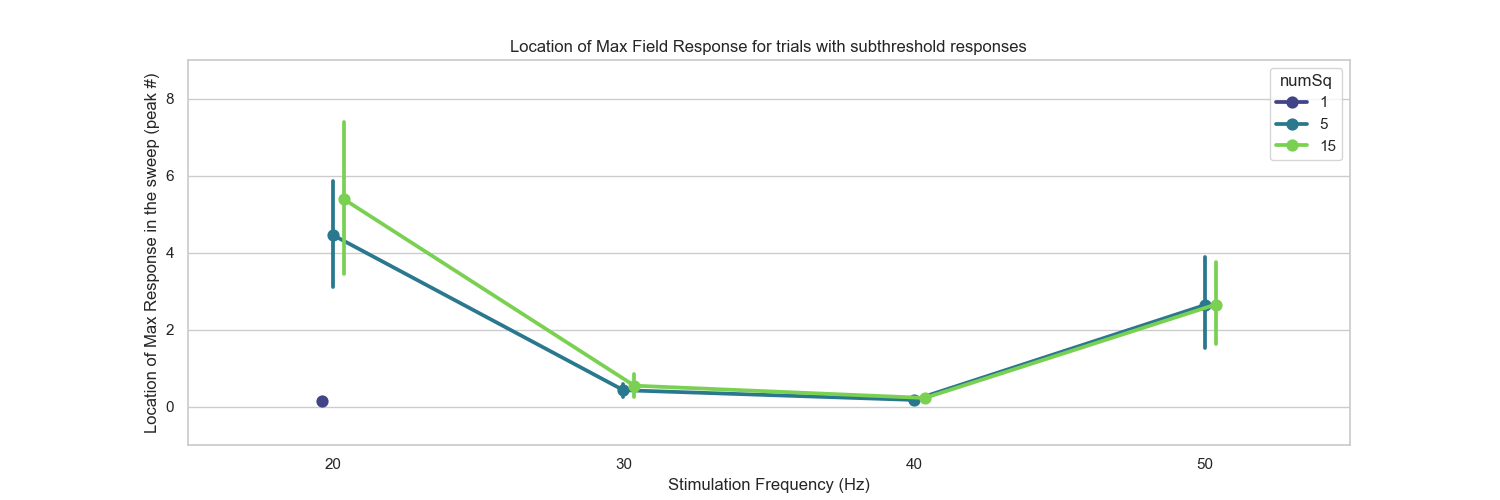

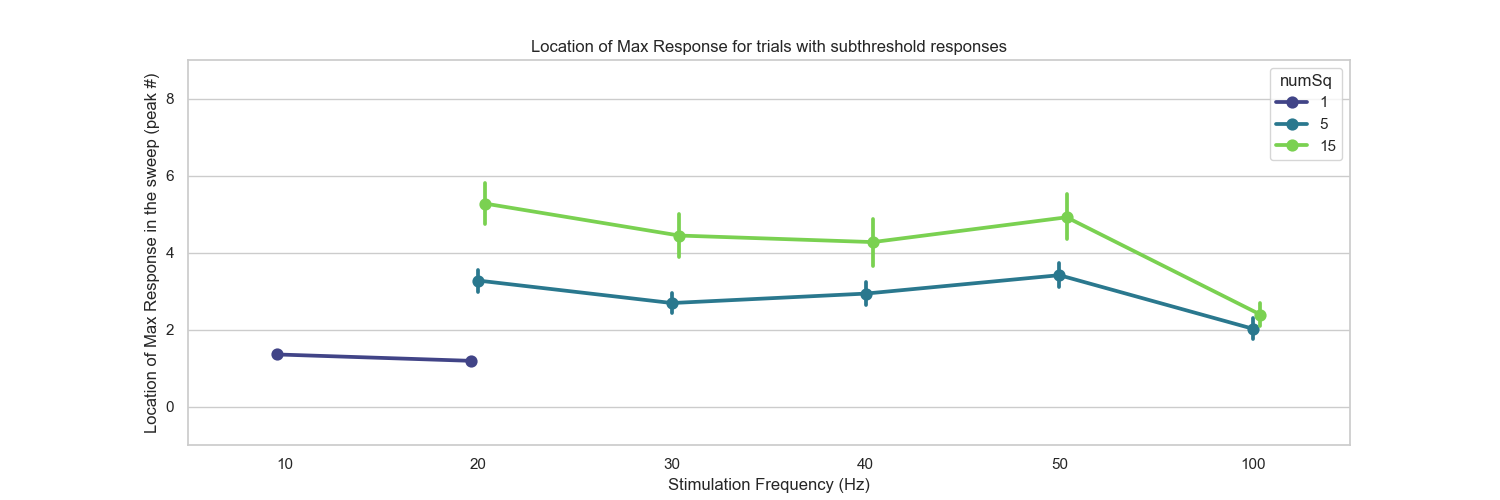

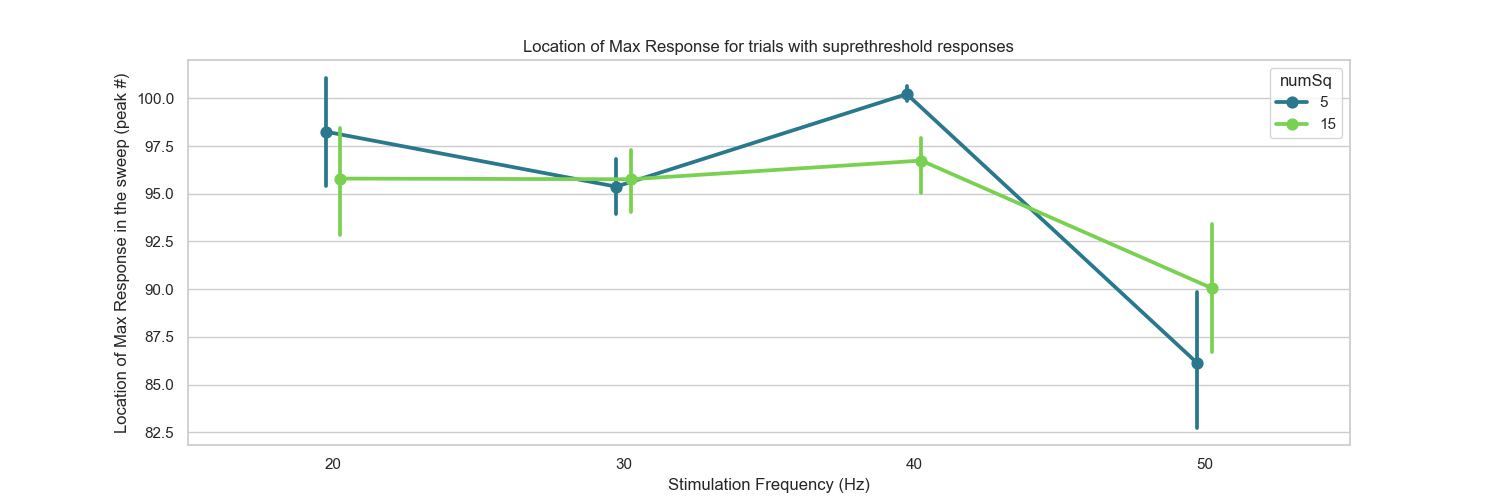

In [11]:
# a violinplot of peak_cell_loc vs numSq and stimFreq
plt.figure(figsize=(15,5))
# whitegrid
sns.set_theme(style="whitegrid")
ax = sns.pointplot(data=expanded_df_field, hue='numSq', y='peak_field_max_value', x='stimFreq', dodge=True, palette=color_squares, errorbar='ci')  #[(expanded_df_field['peak_field_max_value']<30)]
# set ylim
ax.set_ylim(-1,9)
# xlabel
plt.xlabel('Stimulation Frequency (Hz)')
# ylabel
plt.ylabel('Location of Max Response in the sweep (peak #)')
# title
plt.title('Location of Max Field Response for trials with subthreshold responses')
# save the figure
folder_path = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Analysis\paper_figures\Fig4")
plt.savefig(folder_path / 'Field_MaxPeak_vs_numSq_vs_stimFreq_err=ci_subthres.png', dpi=300)
plt.savefig(folder_path / 'Field_MaxPeak_vs_numSq_vs_stimFreq_err=ci_subthres.svg', dpi=300)

# ------------------------------------------------------------------------------------------------------------------
# a violinplot of peak_cell_loc vs numSq and stimFreq
plt.figure(figsize=(15,5))
# whitegrid
sns.set_theme(style="whitegrid")
ax = sns.pointplot(data=expanded_df_cell[(expanded_df_cell['peak_cell_max_value']<30)], hue='numSq', y='peak_cell_max_value', x='stimFreq', dodge=True, palette=color_squares, errorbar='ci')
# set ylim
ax.set_ylim(-1,9)
# xlabel
plt.xlabel('Stimulation Frequency (Hz)')
# ylabel
plt.ylabel('Location of Max Response in the sweep (peak #)')
# title
plt.title('Location of Max Response for trials with subthreshold responses')
# save the figure
folder_path = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Analysis\paper_figures\Fig4")
plt.savefig(folder_path / 'MaxPeak_vs_numSq_vs_stimFreq_err=ci_subthres.png', dpi=300)
plt.savefig(folder_path / 'MaxPeak_vs_numSq_vs_stimFreq_err=ci_subthres.svg', dpi=300)

# ------------------------------------------------------------------------------------------------------------------
# a violinplot of peak_cell_loc vs numSq and stimFreq
plt.figure(figsize=(15,5))
# whitegrid
sns.set_theme(style="whitegrid")
ax = sns.pointplot(data=expanded_df_cell[(expanded_df_cell['peak_cell_max_value']>30)], hue='numSq', y='peak_cell_max_value', x='stimFreq', dodge=True, palette=color_squares, errorbar='ci')
# set ylim
# ax.set_ylim(-1,9)
# xlabel
plt.xlabel('Stimulation Frequency (Hz)')
# ylabel
plt.ylabel('Location of Max Response in the sweep (peak #)')
# title
plt.title('Location of Max Response for trials with suprethreshold responses')
# save the figure
folder_path = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Analysis\paper_figures\Fig4")
plt.savefig(folder_path / 'MaxPeak_vs_numSq_vs_stimFreq_err=ci_suprathres.png', dpi=300)
plt.savefig(folder_path / 'MaxPeak_vs_numSq_vs_stimFreq_err=ci_suprathres.svg', dpi=300)

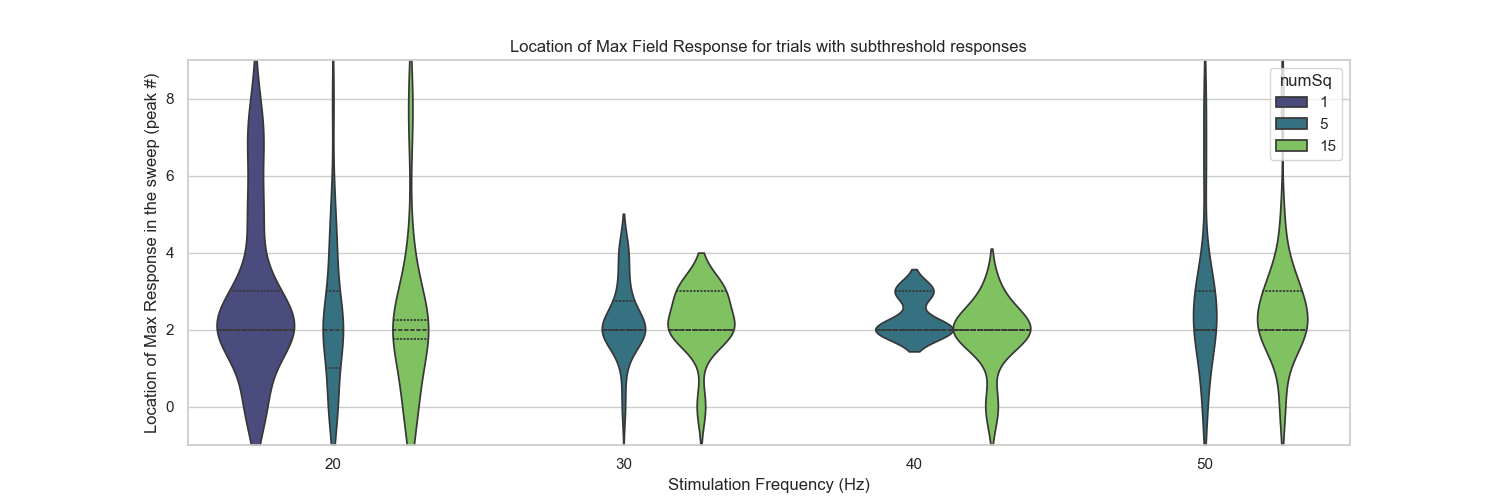

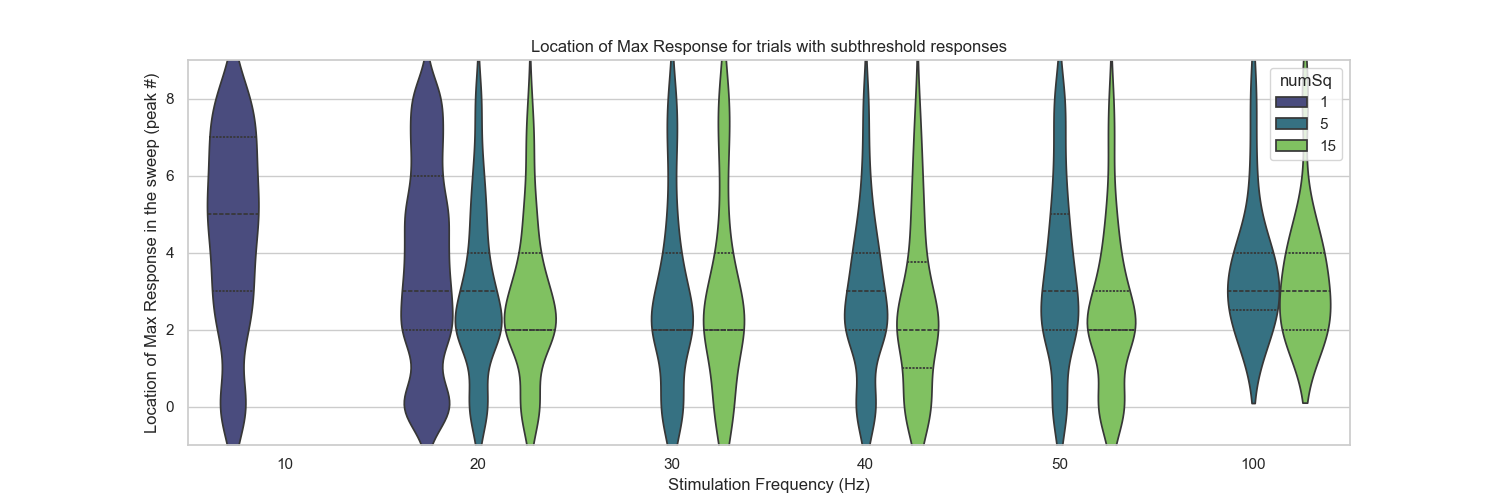

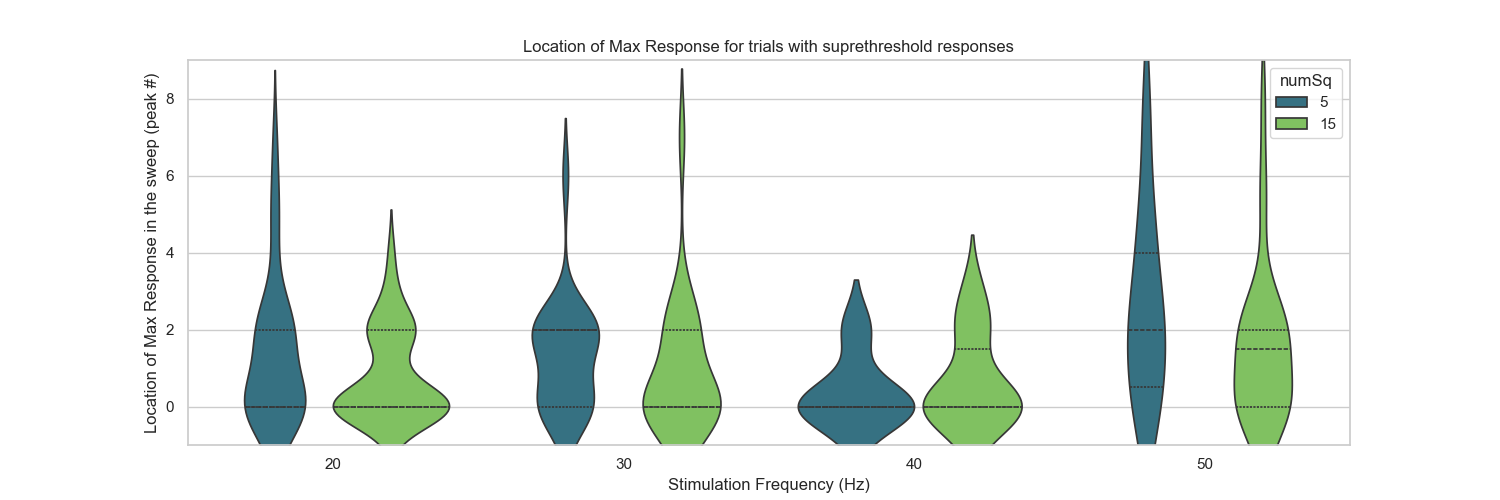

In [89]:
# a violinplot of peak_cell_loc vs numSq and stimFreq
plt.figure(figsize=(15,5))
# whitegrid
sns.set_theme(style="whitegrid")
ax = sns.violinplot(data=expanded_df_field, hue='numSq', y='peak_field_loc', x='stimFreq', dodge=True, palette=color_squares, inner='quart') #errorbar='ci')  #[(expanded_df_field['peak_field_max_value']<30)]
# set ylim
ax.set_ylim(-1,9)
# xlabel
plt.xlabel('Stimulation Frequency (Hz)')
# ylabel
plt.ylabel('Location of Max Response in the sweep (peak #)')
# title
plt.title('Location of Max Field Response for trials with subthreshold responses')
# save the figure
folder_path = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Analysis\paper_figures\Fig4")
plt.savefig(folder_path / 'Field_locMaxPeak_vs_numSq_vs_stimFreq_err=ci_subthres_violins.png', dpi=300)
plt.savefig(folder_path / 'Field_locMaxPeak_vs_numSq_vs_stimFreq_err=ci_subthres_violins.svg', dpi=300)

# ------------------------------------------------------------------------------------------------------------------
# a violinplot of peak_cell_loc vs numSq and stimFreq
plt.figure(figsize=(15,5))
# whitegrid
sns.set_theme(style="whitegrid")
ax = sns.violinplot(data=expanded_df_cell[(expanded_df_cell['peak_cell_max_value']<30)], hue='numSq', y='peak_cell_loc', x='stimFreq', dodge=True, palette=color_squares, inner='quart') #errorbar='ci')
# set ylim
ax.set_ylim(-1,9)
# xlabel
plt.xlabel('Stimulation Frequency (Hz)')
# ylabel
plt.ylabel('Location of Max Response in the sweep (peak #)')
# title
plt.title('Location of Max Response for trials with subthreshold responses')
# save the figure
folder_path = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Analysis\paper_figures\Fig4")
plt.savefig(folder_path / 'locMaxPeak_vs_numSq_vs_stimFreq_err=ci_subthres_violins.png', dpi=300)
plt.savefig(folder_path / 'locMaxPeak_vs_numSq_vs_stimFreq_err=ci_subthres_violins.svg', dpi=300)

# ------------------------------------------------------------------------------------------------------------------
# a violinplot of peak_cell_loc vs numSq and stimFreq
plt.figure(figsize=(15,5))
# whitegrid
sns.set_theme(style="whitegrid")
ax = sns.violinplot(data=expanded_df_cell[(expanded_df_cell['peak_cell_max_value']>30)], hue='numSq', y='peak_cell_loc', x='stimFreq', dodge=True, palette=color_squares, inner='quart') #errorbar='ci')
# set ylim
ax.set_ylim(-1,9)
# xlabel
plt.xlabel('Stimulation Frequency (Hz)')
# ylabel
plt.ylabel('Location of Max Response in the sweep (peak #)')
# title
plt.title('Location of Max Response for trials with suprethreshold responses')
# save the figure
folder_path = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Analysis\paper_figures\Fig4")
plt.savefig(folder_path / 'locMaxPeak_vs_numSq_vs_stimFreq_err=ci_suprathres_violins.png', dpi=300)
plt.savefig(folder_path / 'locMaxPeak_vs_numSq_vs_stimFreq_err=ci_suprathres_violins.svg', dpi=300)

In [8]:
# make a long form dataframe for seaborn plotting
# the values for peak_cell_columns should be in a single column with a new column for the peak type
# identifiers are 'numSq', 'stimFreq'

df_long = pd.melt(expanded_df_cell, id_vars=['cellID', 'trialID', 'numSq', 'stimFreq'], value_vars=peak_cell_columns, var_name='peak_type', value_name='peak_value') 
df_long_field = pd.melt(expanded_df_field, id_vars=['cellID', 'trialID', 'numSq', 'stimFreq'], value_vars=peak_field_columns, var_name='peak_type', value_name='peak_value') 

In [9]:
df_long['numSq'] = df_long['numSq'].astype('int')
df_long['stimFreq'] = df_long['stimFreq'].astype('int')

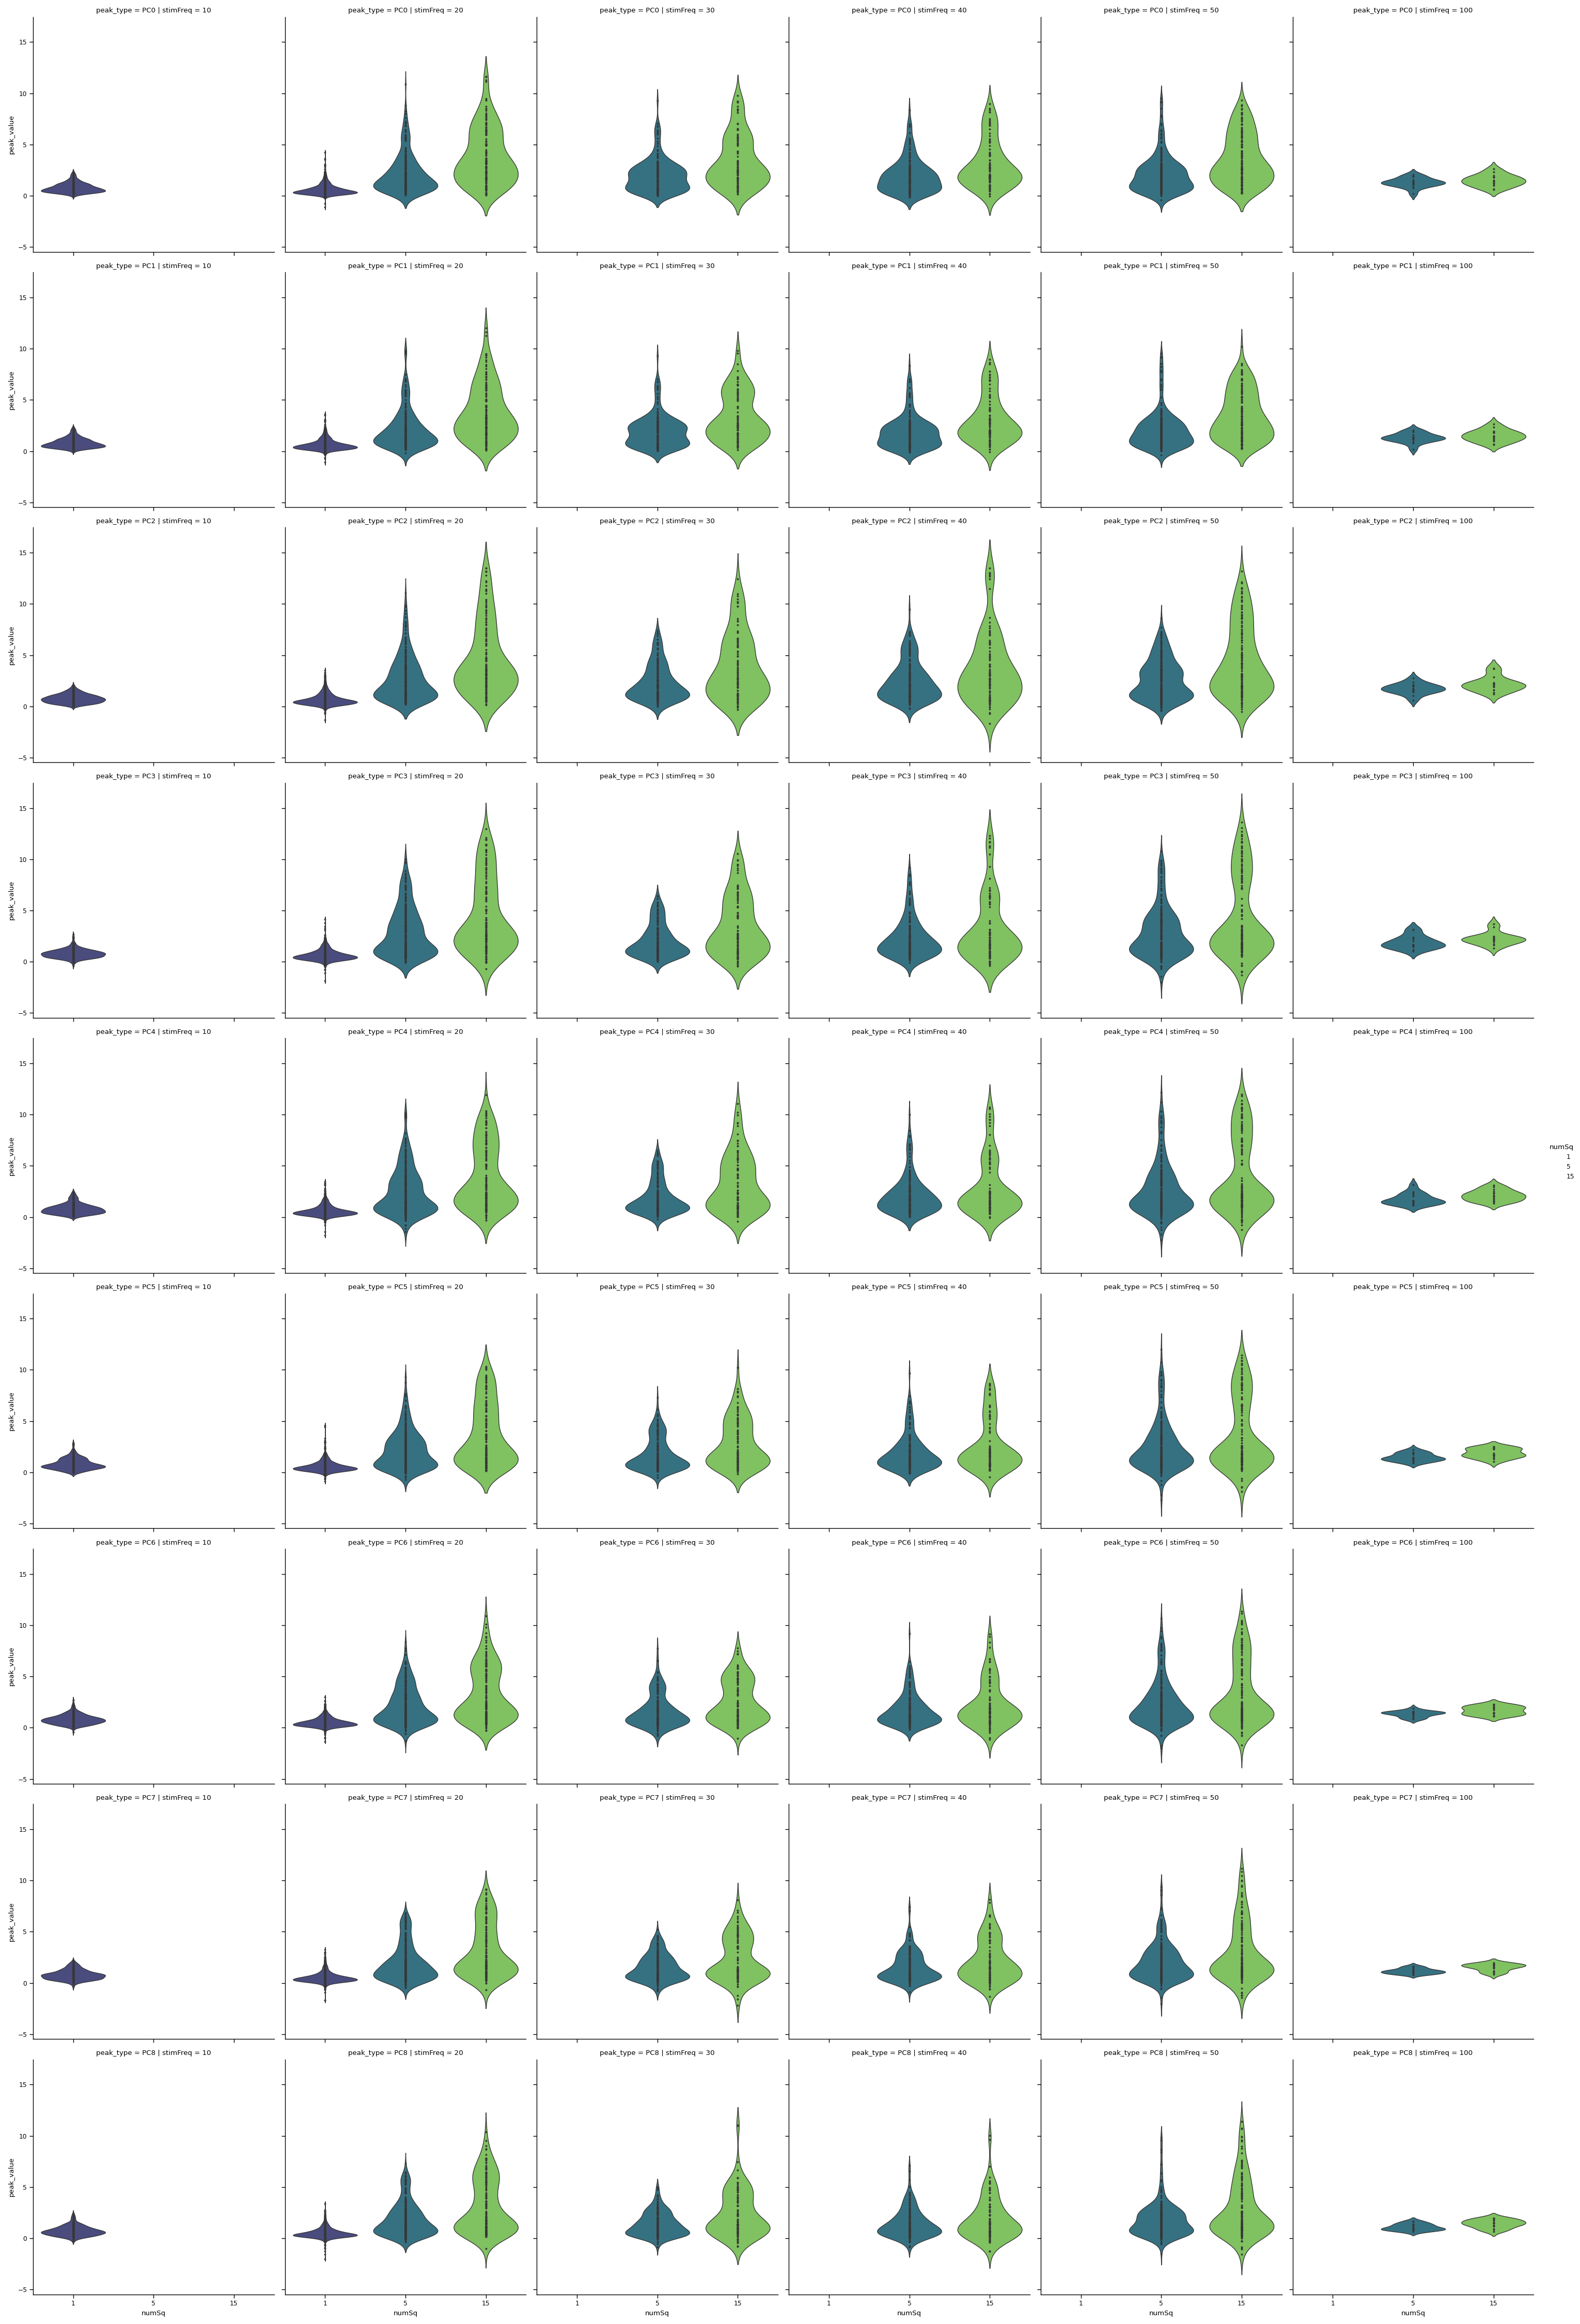

In [39]:
# make a facetgrid of violin plots for peak values for different peak types and numSq and stimFreq
g = sns.catplot(df_long[(df_long['peak_value']<30)], y='peak_value', x='numSq', row='peak_type', col='stimFreq', hue='numSq', sharex=True, sharey=True, palette=color_squares,hue_order=[1,5,15],kind='violin',inner='point')


c:\venvs\venv-ephys\Lib\site-packages\seaborn\categorical.py:3370: UserWarning: 29.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\venvs\venv-ephys\Lib\site-packages\seaborn\categorical.py:3370: UserWarning: 33.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\venvs\venv-ephys\Lib\site-packages\seaborn\categorical.py:3370: UserWarning: 12.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\venvs\venv-ephys\Lib\site-packages\seaborn\categorical.py:3370: UserWarning: 28.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\venvs\venv-ephys\Lib\site-packages\seaborn\categorical.py:3370: UserWarning: 36.2% of the points cannot be placed; you ma

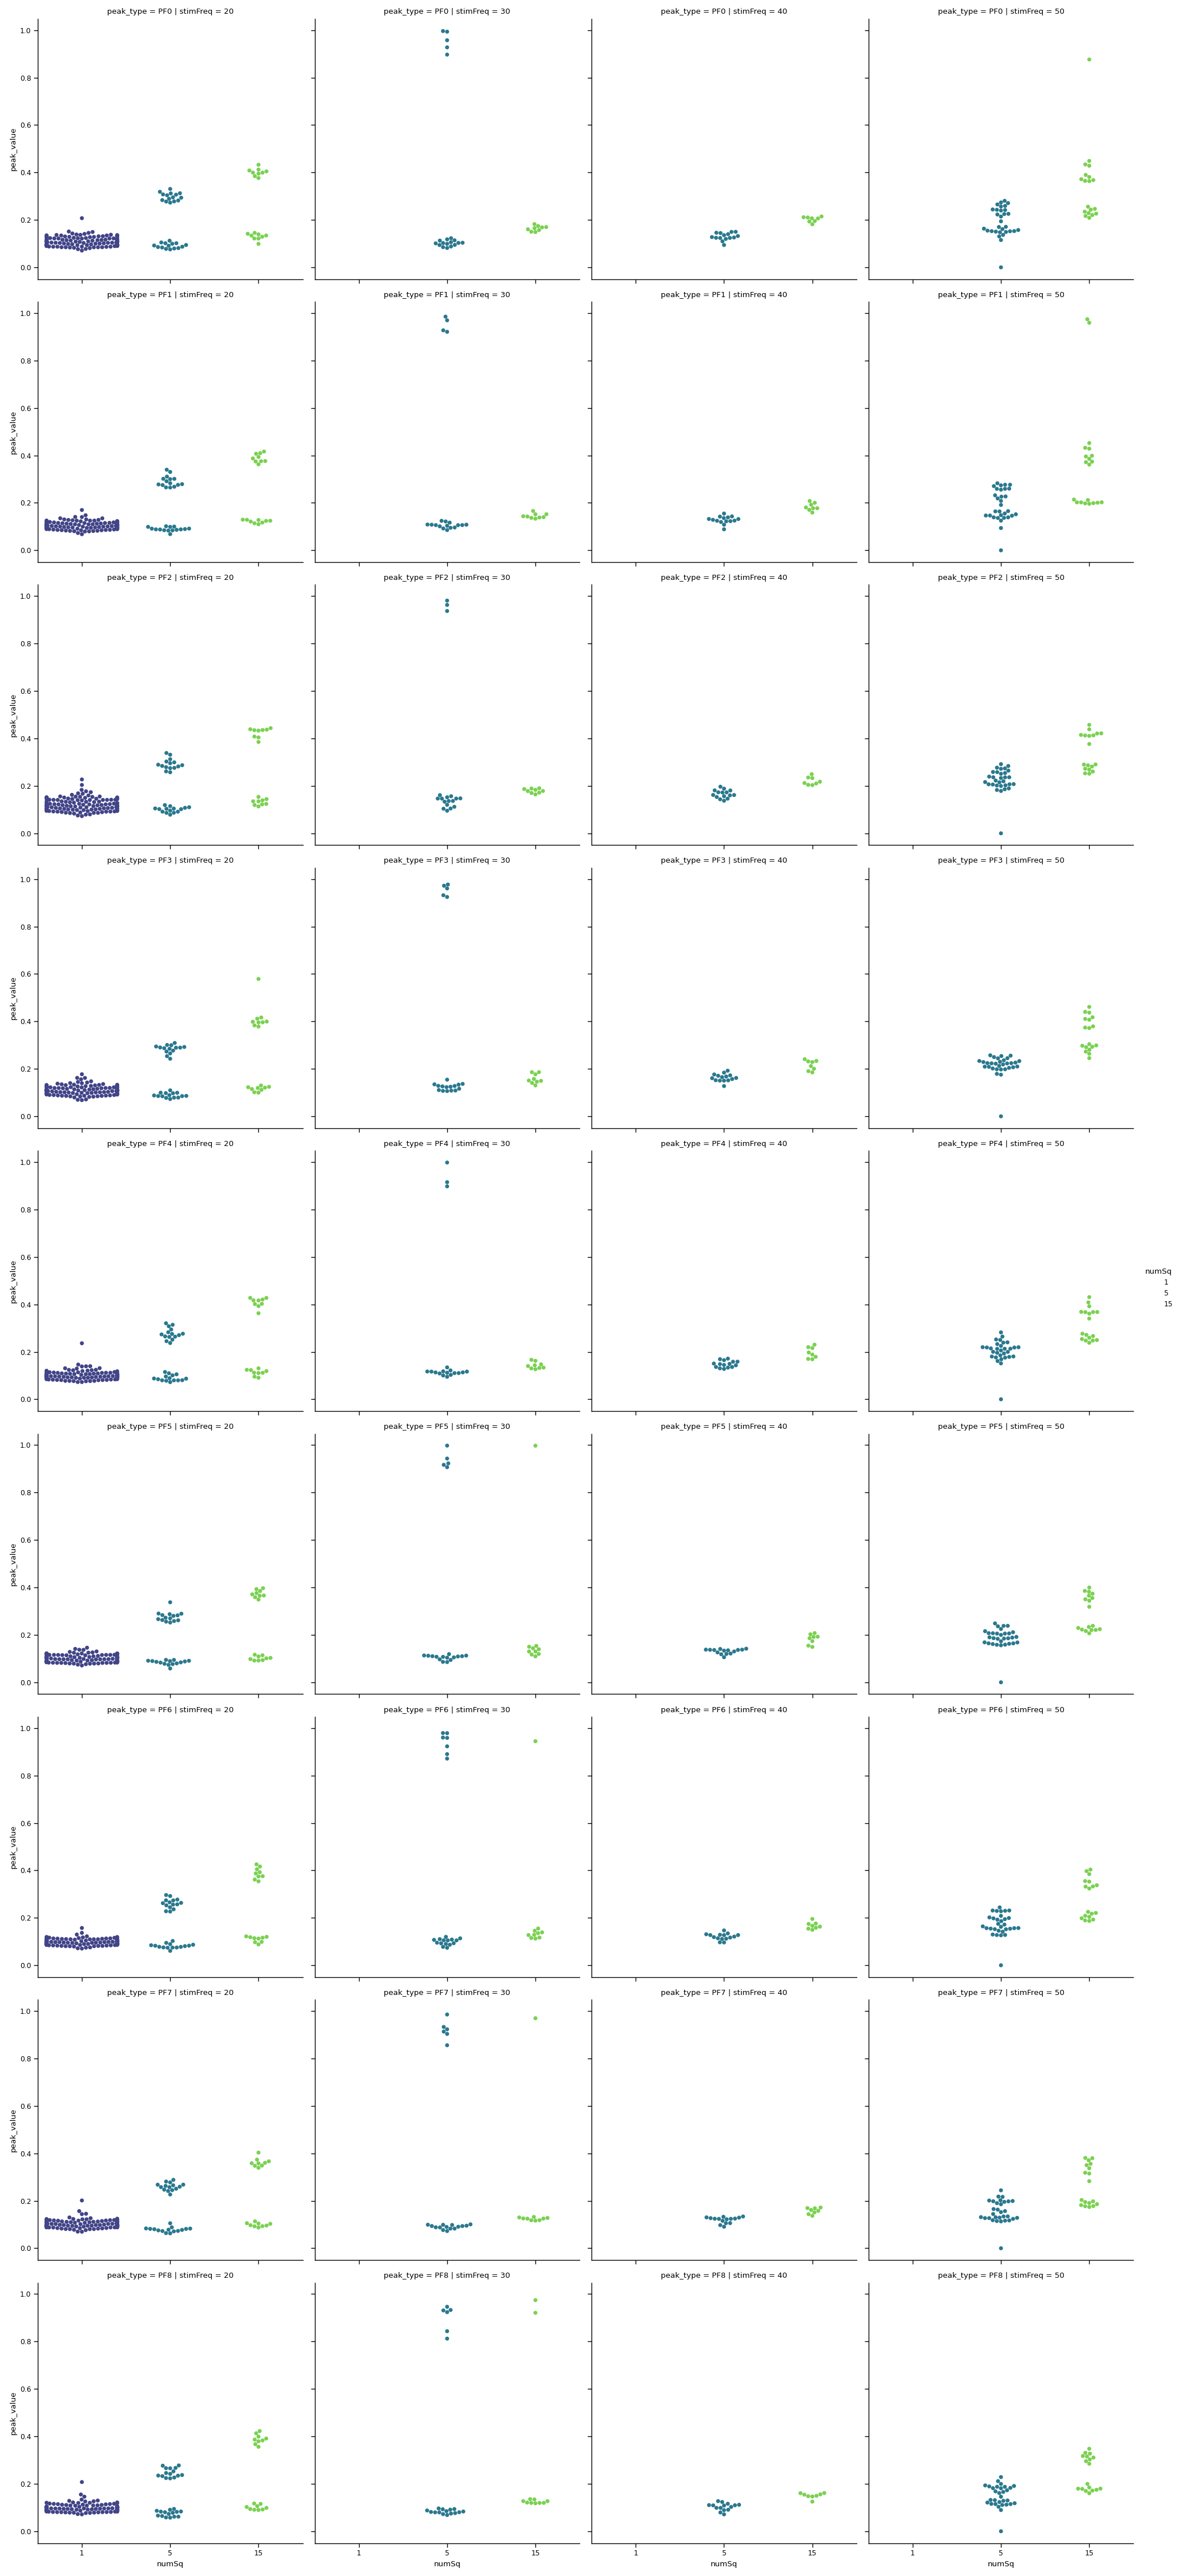

In [40]:
# make a facetgrid of violin plots for peak values for different peak types and numSq and stimFreq
# sns.set(style="whitegrid")
gf = sns.catplot(df_long_field[(df_long_field['peak_value']<1)], y='peak_value', x='numSq', row='peak_type', col='stimFreq', hue='numSq', sharex=True, sharey=True, palette=color_squares,hue_order=[1,5,15],kind='swarm')

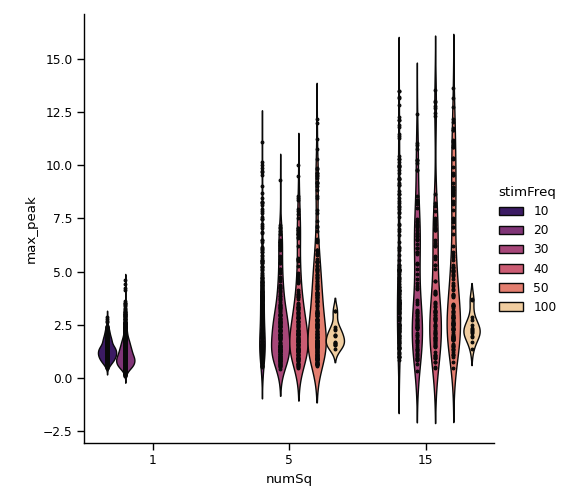

In [48]:
# to the dataframe expanded_df_cell add a column with the maximum peak value and its peak type
expanded_df_cell['max_peak'] = expanded_df_cell[peak_cell_columns].max(axis=1)
expanded_df_cell['max_peak_type'] = expanded_df_cell[peak_cell_columns].idxmax(axis=1)
# make a plot of max peak value for each stimFreq and numSq
magma   = mpl.colormaps["magma"]
color_freq = {1:magma(0.05), 5:magma(0.1), 10:magma(0.2), 20:magma(.4), 30:magma(.5), 40:magma(.6), 50:magma(.7), 100:magma(.9)}
g = sns.catplot(expanded_df_cell[(expanded_df_cell['max_peak']<30)], x='numSq', y='max_peak', hue='stimFreq', kind='violin', palette=color_freq, inner='points')

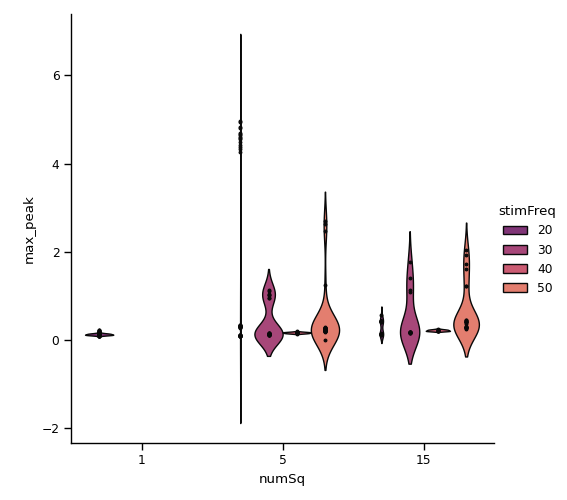

In [50]:
# to the dataframe expanded_df_field add a column with the maximum peak value and its peak type
expanded_df_field['max_peak'] = expanded_df_field[peak_field_columns].max(axis=1)
expanded_df_field['max_peak_type'] = expanded_df_field[peak_field_columns].idxmax(axis=1)
# make a plot of max peak value for each stimFreq and numSq
magma   = mpl.colormaps["magma"]
color_freq = {1:magma(0.05), 5:magma(0.1), 10:magma(0.2), 20:magma(.4), 30:magma(.5), 40:magma(.6), 50:magma(.7), 100:magma(.9)}
g = sns.catplot(expanded_df_field[(expanded_df_field['max_peak']<5)], x='numSq', y='max_peak', hue='stimFreq', kind='violin', palette=color_freq, inner='points')